# ME 592 Final Project
## Jake Bergfeld, Mohammad Rashid Mohammad Shoaib
#### Engineering Image Analysis - Automated Chest X-ray classifier

##### Gathering data from Kaggle - Link to data: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
# !pip install kaggle
# !mkdir .kaggle  #naming required by kaggle API, creates a hidden folder
# !cp /home/exouser/Downloads/kaggle.json /home/exouser/.kaggle/kaggle.json

##### <u>Confirming location of Kaggle API token was moved successfully

In [2]:
# !cd .kaggle && ls

##### <u>Downloading the specific dataset and confirming locations

In [185]:
# !kaggle datasets list -s 'Chest X-ray images'

In [4]:
# !kaggle datasets download -d 'paultimothymooney/chest-xray-pneumonia'

In [5]:
# !sudo apt-get install unzip
# !unzip chest-xray-pneumonia.zip /home/exouser/ME592/Final Project

### <u>Data Information: 

### Input image size varies
    
##### The 2 classes to predict are:
 - Normal/Healthy lungs
 - Pneumonia

##### *Formula to calculate the number of parameters in a CNN:*
   -  Convolutional layer: (in_channels x out_channels x kernel_height x kernel_width) + out_channels
   -  Batch normalization layer: 2 x num_features
   -  ReLU activation layer: 0 (no parameters)
   -  Max pooling layer: 0 (no parameters)
   -  Fully connected layer: (in_features x out_features) + out_features

### <u>Library Imports & Transforming Data

In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import shutil
import random

In [2]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()

cuda


In [33]:
#Transform the input images
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

### <u>Dataloader and Pre-training

In [34]:
#Create a dataloader

#Directory path for the training & test images
train_path='/home/exouser/ME592/Final Project/chest-xray-pneumonia/train'
test_path='/home/exouser/ME592/Final Project/chest-xray-pneumonia/test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=16, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=16, shuffle=True
) 


In [35]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)


['NORMAL', 'PNEUMONIA']


### <u>Step 1: Build and train a CNN model

In [36]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.relu1 = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.relu3 = nn.ReLU()

        self.fc1 = nn.Linear(in_features=128 * 18 * 18, out_features=1024)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.pool(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.pool(output)

        output = output.view(-1, 128 * 18 * 18)
        output = self.fc1(output)
        output = self.relu4(output)
        output = self.fc2(output)
        
        #Final layer can be a sigmoid activation layer since only using 2 classes. This will help push the network, on/off functionality. Should help with test acc

        return output
        

In [37]:
model=ConvNet(num_classes=2).to(device)

In [38]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.003,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
# loss_function=nn.BCELoss()
#Since binary problem, can use Binary cross entropy function instead to perform the sigmoid entropy automatically (numerical stability)

In [39]:
num_epochs=20

In [40]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpeg'))
test_count=len(glob.glob(test_path+'/**/*.jpeg'))

In [41]:
print(train_count)
print(test_count)

5216
624


In [42]:
train_acc_list = []
test_acc_list = []
loss_list = []

In [43]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    # print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy))

    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)
    loss_list.append(train_loss)
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
    
       

Epoch: 0 Train Loss: tensor(2.0177) Train Accuracy: 0.9292561349693251 Test Accuracy: 0.7980769230769231
Epoch: 1 Train Loss: tensor(0.1077) Train Accuracy: 0.9616564417177914 Test Accuracy: 0.7131410256410257
Epoch: 2 Train Loss: tensor(0.1108) Train Accuracy: 0.9559049079754601 Test Accuracy: 0.7996794871794872
Epoch: 3 Train Loss: tensor(0.0881) Train Accuracy: 0.9683665644171779 Test Accuracy: 0.6778846153846154
Epoch: 4 Train Loss: tensor(0.0973) Train Accuracy: 0.964340490797546 Test Accuracy: 0.6810897435897436
Epoch: 5 Train Loss: tensor(0.1252) Train Accuracy: 0.9570552147239264 Test Accuracy: 0.8253205128205128
Epoch: 6 Train Loss: tensor(0.1156) Train Accuracy: 0.9616564417177914 Test Accuracy: 0.7724358974358975
Epoch: 7 Train Loss: tensor(0.1500) Train Accuracy: 0.9593558282208589 Test Accuracy: 0.7291666666666666
Epoch: 8 Train Loss: tensor(0.0881) Train Accuracy: 0.9691334355828221 Test Accuracy: 0.7419871794871795
Epoch: 9 Train Loss: tensor(0.0607) Train Accuracy: 0.97

In [44]:
# train_acc_list.append(train_accuracy)
# test_acc_list.append(test_accuracy)
# loss_list.append(train_loss)

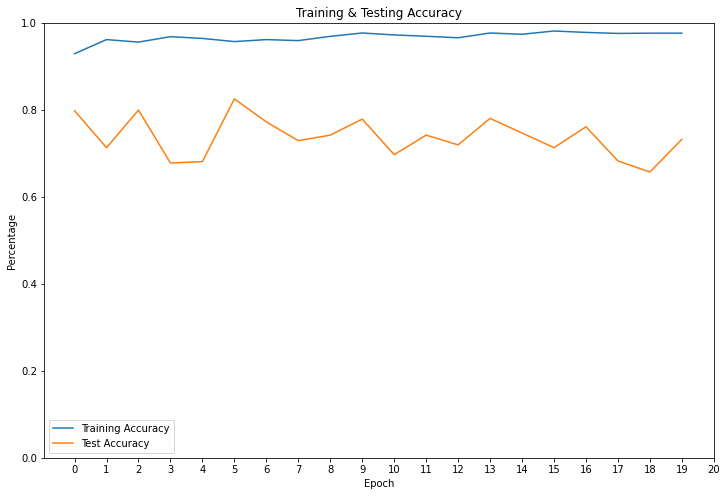

In [45]:
# Plot the results
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,8))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xticks(range(21))
plt.ylim(0,1)
plt.show()

### <u>Now using unlabeled images to evaluate the network:

In [57]:
#Loading more libraries
import torch
import torch.nn as nn
import numpy as np
import torch.functional as F
import os
import pathlib
import glob
import cv2
from torch.autograd import Variable
from torchvision import transforms as T, datasets
from torchvision.models import squeezenet1_1
from io import open
from PIL import Image
import matplotlib.pyplot as plt

In [58]:
pred_path='/home/exouser/ME592/Final Project/chest-xray-pneumonia/val'

In [59]:
checkpoint=torch.load('best_checkpoint.model')
model=ConvNet(num_classes=2)
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc1): Linear(in_features=41472, out_features=1024, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

In [60]:
#Transform the prediction input images
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [61]:
#Prediction function
def prediction(img_path,transformer):
    
    image=Image.open(img_path)
    image_tensor=transformer(image).float()
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor=image_tensor.cuda()
        
    input=Variable(image_tensor)
    
    output=model(input)
    index=output.data.numpy().argmax()
    pred=classes[index]
    
    return pred

In [62]:
#Defining a class to store hyperparameters and file paths used in the code for easy modification.
class CFG:
    # define the hyperparameters
    epochs = 20                                         # No. of epochs of training the model 
    lr = 0.001                                         # Learning rate 
    batch_size = 16                                    # Batch Size For Dataset 
    img_size = 224
        
    #Directory path for the training & test images
    DATA_DIR ="/home/exouser/ME592/Final Project/chest-xray-pneumonia"
    TEST = 'test'                                      # Test folder name in data directory 
    TRAIN = 'train'                                    # Train folder name in data directory 
    VAL ='val'                                         # Valid folder name in data directory 

In [64]:
train_transform = T.Compose([
            
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.RandomRotation(degrees = (-20,+20)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

valid_transform = T.Compose([
    
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    
    T.Resize(size = (CFG.img_size,CFG.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [65]:
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)

trainset = datasets.ImageFolder(train_path,transform = train_transform)
validset = datasets.ImageFolder(valid_path,transform = valid_transform)
testset = datasets.ImageFolder(test_path,transform = test_transform)

In [ ]:
def view_classify(image,ps,label):
    
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Actual Label : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    
# Select a random index from 0 to 623
idx = random.randint(0, 623)
print('Image Index # = ',idx)
image,label = testset[idx] # enter the image index

logit = model(image.to(device).unsqueeze(0)) 
ps = F.softmax(logit,dim = 1)

view_classify(image,ps,label)